# Logistic Regression with Deep neural network 

This project will be step-by-step building the neural network from scratch, including running forward and backward propagation and model optimization. 

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import pickle

# Define activation function
In this project, we are going to use sigmoid and RELU (Rectified Linear Unit) activation functions.

In [2]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache=Z
    return A,cache

def relu(Z):
    A=np.maximum(0,Z)
    cache = Z
    return A,cache

def sigmoid_backward(dA,cache):
    Z=cache
    s=1/(1+np.exp(-Z))
    dZ=dA*s*(1-s) #s*(1-s) is the derivative of the function
    return dZ

def relu_backward(dA,cache):
    Z=cache
    dZ=np.array(dA,copy=True)
    dZ[Z<=0]=0
    return dZ

# Create parameters (weights and bias)

The two main parameters for neural network is the weights (w) and bias (b)

In [3]:
def initialize_parameters_deep(layers_dims):
    np.random.seed(1)
    L=len(layers_dims)
    parameters = {}
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1])/np.sqrt(layers_dims[l-1])
        parameters[f'b{l}']=np.zeros((layers_dims[l],1))

    return parameters

# Forward Propagation
## Linear function

This linear function will compute the linear equation (weight*input+bias) which is a simple linear regression equation

In [4]:
def linear_forward(A,W,b):
    Z=np.dot(W,A)+b
    cache=(A,W,b)
    return Z,cache

## Activate the linear function using activation functions (sigmoid and RELU)

for layer 0 to n-1 where n=output layer, we use RELU function which is the maximum (0,Z) where Z=linear equation.    

for the output layer, we use sigmoid function which is a commom activation function for logistic regression to activate the linear equation

In [5]:
def linear_activation_forward(A_prev,W,b,activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation=='sigmoid':
        A,activation_cache=sigmoid(Z)
    elif activation=='relu':
        A,activation_cache=relu(Z)
    cache=(linear_cache,activation_cache)
    return A,cache


## Compute the final output

Now we put all functions together to finish our forward propagation and produce the output y-hat

In [6]:
def L_model_forward(X,parameters):
    caches=[]
    A=X
    L=len(parameters)//2
    for l in range(1,L):
        A_prev=A
        A,cache=linear_activation_forward(A_prev,parameters[f'W{l}'],parameters[f'b{l}'],activation='relu')
        caches.append(cache)
    AL,cache=linear_activation_forward(A,parameters[f'W{L}'],parameters[f'b{L}'],activation='sigmoid')
    caches.append(cache)
    return AL,caches

# Cost Function

The cost is the average of the loss function which is  -(1 / m) * (np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T))

One of the goals for this project is to minimize the cost function so that the model is optimized

In [7]:
def compute_cost(AL,Y):
    m=Y.shape[1]
    cost = (1. / m) * (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T))
    cost=np.squeeze(cost)
    return cost

# Backward propagation

## Derivative of the sigmoid and RELU functions

We reached to the output layer to compute the final output y-hat.

Now, we will be computing the gradient descent to find the optimal weight and bias so that the cost function is minimized.

In [8]:
def linear_backward(dZ,cache):
    A_prev,W,b=cache
    m=A_prev.shape[1]
    dW=np.dot(dZ,A_prev.T)/m
    db=np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev=np.dot(W.T,dZ)
    return dA_prev,dW,db

## Backward linear activation

This time we start from the output layer which was activated by a sigmoid function. 

Then we repeatedly compute the derivative of the RELU function form layer n-1 to the input layer where n=output layer.

In [9]:
def linear_activation_backward(dA,cache,activation):
    linear_cache, activation_cache = cache  #linear_cache contain a,w,b #activation_cache contain Z
    if activation=='sigmoid':
        dZ=sigmoid_backward(dA,activation_cache)
    elif activation=='relu':
        dZ = relu_backward(dA, activation_cache)
    dA_prev,dW,db=linear_backward(dZ,linear_cache)
    return dA_prev,dW,db

In [10]:
def L_model_backward(AL,Y,caches):
    L=len(caches)
    grads={}
    m=AL.shape[1]
    Y=Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache=caches[-1]
    dA_prev,dW,db=linear_activation_backward(dAL,current_cache,activation='sigmoid')
    grads[f'dA{L-1}']=dA_prev
    grads[f'dW{L}']=dW
    grads[f'db{L}'] = db
    for l in reversed(range(L-1)):
        current_cache=caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,
                                                                    activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

# Finding the optimal weights and bias 

The following function will continuously update the parameters to find the global minimum for the cost function

In [11]:
def update_parameters(params,grads,learning_rate):
    parameters=params.copy()
    L=len(parameters)//2
    for l in range(L):
        parameters[f'W{l+1}']-=learning_rate*grads['dW'+ str(l+1)]
        parameters[f'b{l + 1}']-= learning_rate * grads['db' + str(l + 1)]
    return parameters


# Putting all together

Now we have a model that iterates over 2500 times to gradually reduce the costs.

The process for the "for" loop is the following:

- Compute the final output using the parameters (w,b)
- Compute the cost
- Compute the gradients
- updating the parameters (w,b) by subtracting the gradient*learning rate
- repeat from step 1 with the new parameters (w,b)


In [31]:
def L_layer_model(X,Y,layers_dims,learning_rate=0.0075,num_iterations=2500,print_cost=False):
    costs=[]
    parameters=initialize_parameters_deep(layers_dims)
    for i in range(num_iterations):
        AL,caches=L_model_forward(X,parameters)
        cost=compute_cost(AL,Y)
        grads=L_model_backward(AL,Y,caches)
        parameters=update_parameters(parameters,grads,learning_rate)
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

In [24]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2  # number of layers in the neural network
    p = np.zeros((1, m))

    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    print("Accuracy: " + str(np.sum((p == y) / m)))

    return p

# Input file

The dataset we're going to use is 'gender_df' which has every column=a (64*64*3) picture represented by an array with shape (64*64*3,1) and every row=number of examples in the dataset

In [33]:
input_file=open('gender_df.dat','rb')
gender_df=pickle.load(input_file,encoding='utf-8')

# Isolate the y-variable

In [34]:
y_orig=gender_df.iloc[12288].values
gender_df.drop(12288,inplace=True)
y=y_orig.reshape(1,y_orig.shape[0])

# Spliting the dataset

In order to use the train_test_split function, we need to make sure the x.shape[0]== y.shape[0].

After running the function, we can use the transpose function to make x and y variables the correct shape

test_x.shape= (12288,3011) # 12288 is the input array for the picture, 3011 is the numbers of example.

test_y.shape= (1,3011) 

In [35]:
train_x_orig, test_x_orig, train_y, test_y = train_test_split(gender_df.values.T, y.T, test_size=0.20, random_state=42)
train_x=train_x_orig.T/255
test_x=test_x_orig.T/255
train_y=train_y.T
test_y=test_y.T

In [36]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(12288, 3011)
(12288, 753)
(1, 3011)
(1, 753)


# Train the model 

In [37]:
layers_dims=[train_x.shape[0],20,7,1]
parameters, costs=L_layer_model(train_x,train_y,layers_dims,print_cost=True)

Cost after iteration 0: 0.7032042616607062
Cost after iteration 100: 0.6617295042647837
Cost after iteration 200: 0.6483550511316007
Cost after iteration 300: 0.6462529591903434
Cost after iteration 400: 0.6288789748475334
Cost after iteration 500: 0.6189668940945164
Cost after iteration 600: 0.6121347565063447
Cost after iteration 700: 0.602008819526481
Cost after iteration 800: 0.5949677227778765
Cost after iteration 900: 0.5909292710217064
Cost after iteration 1000: 0.603763749910969
Cost after iteration 1100: 0.6158665592332478
Cost after iteration 1200: 0.571350441643209
Cost after iteration 1300: 0.5646769510627622
Cost after iteration 1400: 0.5566091729031344
Cost after iteration 1500: 0.5512981634252667
Cost after iteration 1600: 0.5443162978244599
Cost after iteration 1700: 0.5352889527421228
Cost after iteration 1800: 0.5315711692688355
Cost after iteration 1900: 0.49405277944269826
Cost after iteration 2000: 0.4879522831212466
Cost after iteration 2100: 0.5740292250575438
Co

In [ ]:
pred_train = predict(train_x,train_y,parameters)
pred_test = predict(test_x, test_y, parameters)

# Make a prediction with an image

In [44]:
def single_predictiion(X, parameters):
    m = X.shape[1]
    n = len(parameters) // 2  # number of layers in the neural network

    probas, caches = L_model_forward(X, parameters)
    if probas > 0.5:
        p='Male'
    elif probas <=0.5:
        p='Female'
    return p

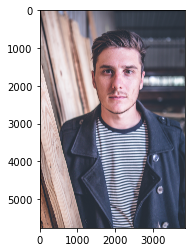

In [40]:
fname='timothy-barlin-FGaknWvNbBk-unsplash.jpg' 
image=np.array(Image.open(fname))
plt.imshow(image)

In [45]:
image=np.array(Image.open(fname).resize((64, 64))) # conver the pixel into (64,64,3) format
image=image/255 
image1=image.reshape(image.shape[0]*image.shape[1]*image.shape[2],1)
print(f'The model predicts it is a {single_predictiion(image1,parameters)} picture!')

The model predicts it is a Male picture!
